In [1]:
import csv
from collections import defaultdict
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm


In [33]:
# load data

class Child():
    def __init__(self, data):
        self.id = data[1]
        self.family = data[0]
        self.relatedness = data[2]
        self.sex = data[5]
        self.age = None if data[6]=='' or int(data[6])<0 or int(data[6])>100 else int(data[6])
        self.diagnoses = set(data[7].split(','))
        self.asd = data[8]
        self.premature = data[9]
        self.gestation = 40 if data[10]=='' else int(data[10])
        self.verbal = data[11]
        self.sleep = data[12]
        self.hearing = data[13]
        self.vision = data[14]
        self.noise = data[15]
        self.motor = data[16]
        self.metabolic = data[17]
        self.gi = data[18]
        self.infections = data[19]
        self.seizures = data[20]
        
    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

fam_to_children = defaultdict(list)
with open('../data/kfPedsFileExport_09-12-2022.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for line in reader:
        child = Child(line)
        fam_to_children[child.family].append(child)

In [34]:
print(set(sum([[x.relatedness for x in children] for children in fam_to_children.values()], [])))

{'stepfather', 'stepmother', 'unrelated', 'full'}


In [38]:
class SiblingPair():
    def __init__(self, child1, child2):        
        self.child1 = child1
        self.child2 = child2
        
        
full_sib = []
half_sib_maternal = []
half_sib_paternal = []
unrelated_family = []
unrelated = []
for fam, children in fam_to_children.items():
    for child1, child2 in combinations(children, r=2):
        if child1.relatedness == 'full' and child2.relatedness == 'full':
            full_sib.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'full' and child2.relatedness == 'stepmother') or \
            (child2.relatedness == 'full' and child1.relatedness == 'stepmother'):
            half_sib_paternal.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'full' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'full' and child1.relatedness == 'stepfather'):
            half_sib_maternal.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'full' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'full' and child1.relatedness == 'unrelated'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'stepmother') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'stepmother'):
            pass
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'stepfather'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'unrelated'):
            pass
        elif (child1.relatedness == 'stepfather' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'stepfather' and child1.relatedness == 'stepfather'):
            pass
        elif (child1.relatedness == 'stepfather' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'stepfather' and child1.relatedness == 'unrelated'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'unrelated' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'unrelated' and child1.relatedness == 'unrelated'):
            pass
        
families = list(fam_to_children.keys())
for _ in range(len(full_sib)):
    fam1, fam2 = random.sample(families, 2)
    child1 = random.choice(fam_to_children[fam1])
    child2 = random.choice(fam_to_children[fam2])
    unrelated.append(SiblingPair(child1, child2))

    
            
print('full', len(full_sib))
print('half mat', len(half_sib_maternal))
print('half pat', len(half_sib_paternal))
print('unrelated fam', len(unrelated_family))
print('unrelated', len(unrelated))

full 1415
half mat 239
half pat 72
unrelated fam 92
unrelated 1415


# Categorical Attributes

In [224]:
#pull_attr = lambda x: 'yes' if 'yes' in x.infections else x.infections
pull_attr = lambda x: x.seizures


In [225]:
options = list(set(sum([[pull_attr(x) for x in children] for children in fam_to_children.values()], [])))
print(options)

options_combos = list(combinations(options, 2)) + [(x, x) for x in options]
options_combos = [x for x in options_combos if x[0] != '' and x[1] != '' and (x[0] != 'no' or x[1] != 'no')]

print(options_combos)

response_to_index = dict()
for i, opt in enumerate(options_combos):
    response_to_index[opt] = i
    response_to_index[(opt[1], opt[0])] = i

['', 'yes', 'no']
[('yes', 'no'), ('yes', 'yes')]


In [226]:
response = np.zeros((len(options_combos), 5))

def pull_sibpair_response(sibpairs, pull_attr):
    r = np.zeros((len(options_combos),))
    for sibpair in sibpairs:
        key = (pull_attr(sibpair.child1), pull_attr(sibpair.child2))
        if key in response_to_index:
            r[response_to_index[key]] += 1
    return r

response[:, 0] = pull_sibpair_response(full_sib, pull_attr)
response[:, 1] = pull_sibpair_response(half_sib_maternal, pull_attr)
response[:, 2] = pull_sibpair_response(half_sib_paternal, pull_attr)
response[:, 3] = pull_sibpair_response(unrelated_family, pull_attr)
response[:, 4] = pull_sibpair_response(unrelated, pull_attr)
print(response)

[[ 86.  14.   2.   5. 129.]
 [  8.   0.   0.   1.   4.]]


In [227]:
def plotbar(r, total, offset=0, label=None):
    p = r/total
    lb, ub = sm.stats.proportion_confint(r, total, alpha=0.05, method='agresti_coull')
    plt.bar(np.arange(len(options_combos))+offset, p, width=0.1, label=label)
    plt.errorbar(np.arange(len(options_combos))+offset, p, 
                 yerr=[p-lb, ub-p], 
                 color='black', linestyle='', capsize=5)


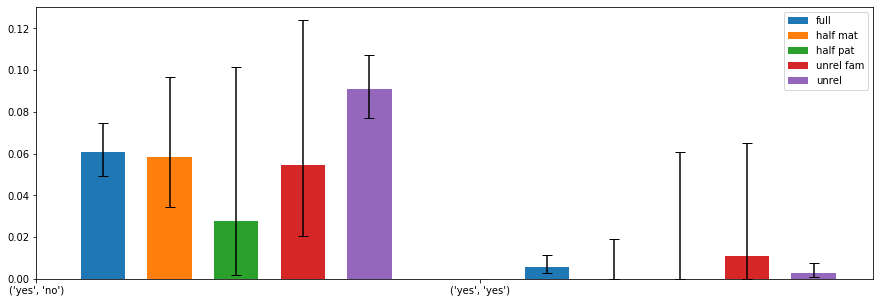

[[ 86.   8.]
 [129.   4.]]
full sib vs unrelated (2.322772751708563, 0.1274925872180169, 1, array([[ 89.030837,   4.969163],
       [125.969163,   7.030837]]))


In [228]:
plt.figure(figsize=(15, 5))
plotbar(response[:, 0], len(full_sib), 0.15, label='full')
plotbar(response[:, 1], len(half_sib_maternal), 0.3, label='half mat')
plotbar(response[:, 2], len(half_sib_paternal), 0.45, label='half pat')
plotbar(response[:, 3], len(unrelated_family), 0.6, label='unrel fam')
plotbar(response[:, 4], len(unrelated), 0.75, label='unrel')
plt.xticks(np.arange(len(options_combos)), [str(x) for x in options_combos])
    
plt.legend()
plt.show()

c = np.array([response[:, 0], response[:, 4]])
print(c)

print('full sib vs unrelated', stats.chi2_contingency(c[:, np.sum(c, axis=0)>5]))
#print('half mat vs unrelated', stats.chi2_contingency([response[:, 1], response[:, 4]]))
#print('half pat vs unrelated', stats.chi2_contingency([response[:, 2], response[:, 4]]))

In [213]:
# **** ASD very genetic
# **** premature very genetic, not enough half-mat sibpairs to distinguish maternal vs paternal impact
# sleep nothing
# hearing nothing, even when grouping yes and yes-other
# **** vision genetic
# noise nothing, even when grouping yes
# motor nothing, even when grouping yes
# **** metabolic - somewhat genetic, limited by sample size
# **** gi genetic
# **** infections genetic, both with and without grouping yes
# seizures nothing - limited by sample size



# Continuous Attributes

In [258]:
pull_attr = lambda x: int(x.gestation)
#max_diff = 10
max_diff = 18

In [259]:
options = list(set(sum([[pull_attr(x) for x in children] for children in fam_to_children.values()], [])))
options_combos = np.arange(max_diff)
print(options)

[32, 33, 34, 35, 36, 37, 40, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [260]:
response = np.zeros((max_diff, 5))

def pull_sibpair_response(sibpairs, pull_attr):
    r = np.zeros((max_diff,))
    for sibpair in sibpairs:
        r[np.abs(pull_attr(sibpair.child1)-pull_attr(sibpair.child2))] += 1
    return r

response[:, 0] = pull_sibpair_response(full_sib, pull_attr)
response[:, 1] = pull_sibpair_response(half_sib_maternal, pull_attr)
response[:, 2] = pull_sibpair_response(half_sib_paternal, pull_attr)
response[:, 3] = pull_sibpair_response(unrelated_family, pull_attr)
response[:, 4] = pull_sibpair_response(unrelated, pull_attr)
print(response)

[[1.167e+03 1.940e+02 6.000e+01 5.400e+01 9.510e+02]
 [1.700e+01 3.000e+00 0.000e+00 0.000e+00 2.000e+01]
 [8.000e+00 2.000e+00 0.000e+00 1.000e+00 1.800e+01]
 [5.400e+01 1.700e+01 3.000e+00 3.000e+00 8.100e+01]
 [7.900e+01 4.000e+00 1.000e+00 2.000e+00 1.030e+02]
 [3.300e+01 9.000e+00 0.000e+00 2.000e+00 9.300e+01]
 [1.900e+01 3.000e+00 4.000e+00 7.000e+00 5.600e+01]
 [8.000e+00 0.000e+00 0.000e+00 3.000e+00 2.400e+01]
 [7.000e+00 6.000e+00 2.000e+00 5.000e+00 2.200e+01]
 [7.000e+00 0.000e+00 0.000e+00 7.000e+00 8.000e+00]
 [2.000e+00 0.000e+00 1.000e+00 5.000e+00 6.000e+00]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00]
 [5.000e+00 0.000e+00 1.000e+00 0.000e+00 8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 3.000e+00 3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00]]


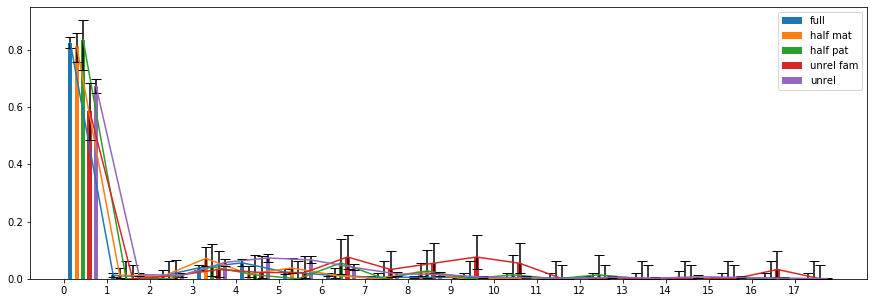

[[1.167e+03 1.700e+01 8.000e+00 5.400e+01 7.900e+01 3.300e+01 1.900e+01
  8.000e+00 7.000e+00 7.000e+00 2.000e+00 4.000e+00 5.000e+00 0.000e+00
  1.000e+00 3.000e+00 0.000e+00 1.000e+00]
 [9.510e+02 2.000e+01 1.800e+01 8.100e+01 1.030e+02 9.300e+01 5.600e+01
  2.400e+01 2.200e+01 8.000e+00 6.000e+00 1.000e+00 8.000e+00 3.000e+00
  1.000e+01 7.000e+00 3.000e+00 1.000e+00]]
full sib vs unrelated (108.98548290038593, 2.95121776816578e-17, 13, array([[1060.12779553,   18.51970181,   13.01384452,   67.57188498,
          91.09691161,   63.06709265,   37.5399361 ,   16.0170394 ,
          14.51544196,    7.50798722,    4.00425985,    6.50692226,
           5.50585729,    5.00532481],
       [1057.87220447,   18.48029819,   12.98615548,   67.42811502,
          90.90308839,   62.93290735,   37.4600639 ,   15.9829606 ,
          14.48455804,    7.49201278,    3.99574015,    6.49307774,
           5.49414271,    4.99467519]]))
half mat vs unrelated (35.1719518490971, 0.005905568939771335, 17, a

In [262]:
plt.figure(figsize=(15, 5))
plotbar(response[:, 0], len(full_sib), 0.15, label='full')
plt.plot(np.arange(0, max_diff)+0.15, response[:, 0]/len(full_sib))

plotbar(response[:, 1], len(half_sib_maternal), 0.3, label='half mat')
plt.plot(np.arange(0, max_diff)+0.3, response[:, 1]/len(half_sib_maternal))

plotbar(response[:, 2], len(half_sib_paternal), 0.45, label='half pat')
plt.plot(np.arange(0, max_diff)+0.45, response[:, 2]/len(half_sib_paternal))

plotbar(response[:, 3], len(unrelated_family), 0.6, label='unrel fam')
plt.plot(np.arange(0, max_diff)+0.6, response[:, 3]/len(unrelated_family))

plotbar(response[:, 4], len(unrelated), 0.75, label='unrel')
plt.plot(np.arange(0, max_diff)+0.75, response[:, 4]/len(unrelated))

plt.xticks(np.arange(len(options_combos)), [str(x) for x in options_combos])
    
plt.legend()
plt.show()

c = np.array([response[:, 0], response[:, 4]])
print(c)

print('full sib vs unrelated', stats.chi2_contingency(c[:, np.sum(c, axis=0)>5]))
print('half mat vs unrelated', stats.chi2_contingency([response[:, 1], response[:, 4]]))
print('half pat vs unrelated', stats.chi2_contingency([response[:, 2], response[:, 4]]))

In [ ]:
# gestation, highly genetic
# verbal, highly genetic, we see mat half sib signal
